In [1]:
from IPython.display import Image
import numpy as np
import pandas as pd
import scipy as sp
import pymc3 as pm
import seaborn as sns
import theano as th
import theano.tensor as tt

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import EllipseCollection
import matplotlib.collections as clt
from functools import reduce

from plotutils import addtxt
mpl.style.use(['./scripts/theme_bw.mplstyle', './scripts/presentation.mplstyle'])

The following example is taken from this paper

[Data Analysis Recipes: Fitting a model to data](https://arxiv.org/abs/1008.4686)

Assume we have some noisy data we wish to fit to our model (in this case a straight line). 

In [2]:
data = pd.DataFrame({'x'  :np.array([201,244, 47,287,203, 58,210,202,198,158,165,201,157,131,166,160,186,125,218,146]),
                     'y'  :np.array([592,401,583,402,495,173,479,504,510,416,393,442,317,311,400,337,423,334,533,344]),
                     'dx' :np.array([  9, 14, 11,  7,  5,  9,  4,  4, 11,  7,  5,  5,  5,  6,  6,  5,  9,  8,  6,  5]),
                     'dy' :np.array([ 61, 25, 38, 15, 21, 15, 27, 14, 30, 16, 14, 25, 52, 16, 34, 31, 42, 26, 16, 22]),
                     'rxy':np.array([-0.84, 0.31, 0.64, -0.27, -0.33, 0.67, -0.02, -0.05, -0.84, -0.69, -.30, -0.46, -0.03, 0.50, 0.73, -0.52, 0.90, 0.40, -0.78, -0.56])})

# Compute covariance matrix
Σ = np.zeros((len(data), 2, 2))
Σ[:,0,0] = data['dx']**2
Σ[:,0,1] = Σ[:,1,0] = data['dx']*data['dy']*data['rxy']
Σ[:,1,1] = data['dy']**2
Σinv     = np.array([np.linalg.inv(s) for s in Σ])

# Compute eigenvalues and eigenvectors to plot uncertainty bounds as ellipses
def eigensolve(sigmas):
    n   = len(sigmas)
    val = np.zeros((n,2))
    vec = np.zeros((n,2,2))
    for i, s in enumerate(sigmas):
        w, v = np.linalg.eig(s)                     # unordered eigenvalues and eigenvectors
        w, v = zip(*sorted(zip(w,np.transpose(v)), reverse=True)) # descending order
        val[i,:]  = np.array(w)
        vec[i,:,:]= np.array(v)
    return val, vec
λ, η = eigensolve(Σ)
θ    = [np.arctan2(v[1],v[0])*180/np.pi for v in η[:,0,:]]    # CCW angle with respect to x-axis of major axis (eigen-vector)

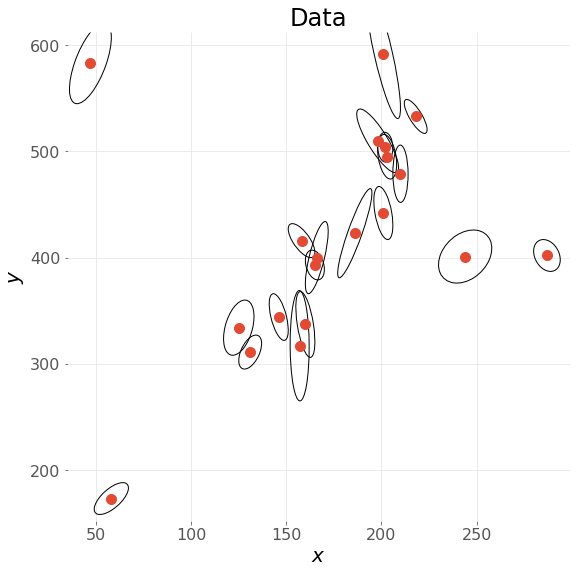

In [4]:
fig = plt.figure(figsize=(9,9))
ax  = fig.add_subplot(111, xlabel=r'$x$', ylabel=r'$y$', title = 'Data')
#ax.errorbar(data['x'],data['y'],yerr=data['dy'], xerr=data['dx'], marker='o', ls='None', label='sampled data', ms=0)
ax.plot(data['x'], data['y'], marker='o', ls='None')
ec   = EllipseCollection(2*np.sqrt(λ[:,0]), 2*np.sqrt(λ[:,1]), θ, units='xy', \
                         offsets=np.column_stack((data['x'],data['y'])), transOffset=ax.transData, edgecolor='k', facecolor='None')
ax.add_collection(ec);

In [5]:
data

,x,y,dx,dy,rxy
0,201,592,9,61,-0.84
1,244,401,14,25,0.31
2,47,583,11,38,0.64
3,287,402,7,15,-0.27
4,203,495,5,21,-0.33
5,58,173,9,15,0.67
6,210,479,4,27,-0.02
7,202,504,4,14,-0.05
8,198,510,11,30,-0.84
9,158,416,7,16,-0.69


For the moment, we will ignore the uncertainties in $x$.

In these situations, where we have outliers, i.e., bad data, a simple fit, minimizing $\chi^2$ is bound to give very bad results

In [6]:
def chi2(p):
    return np.sum((p[0]*data['x'] + p[1] - data['y'])**2/data['dy']**2)
xopt, fopt, gopt, Bopt, fcalls, gcalls, warn = sp.optimize.fmin_bfgs(chi2, np.array([0., 0.]), disp=1, full_output=1)

# y = (<m> + 2*\sigma_m) x + (<b> +/- 2*\sigma_b)
print('y = ({0:.2f} +/- {1:.2f})x + ({2:.0f} +/- {3:.2f})'.format(xopt[0], 2*np.sqrt(Bopt[0][0]*2), xopt[1], 2*np.sqrt(Bopt[1][1]*2)))

Optimization terminated successfully.
         Current function value: 289.963723
         Iterations: 10
         Function evaluations: 64
         Gradient evaluations: 16
y = (1.08 +/- 0.07)x + (213 +/- 10.35)


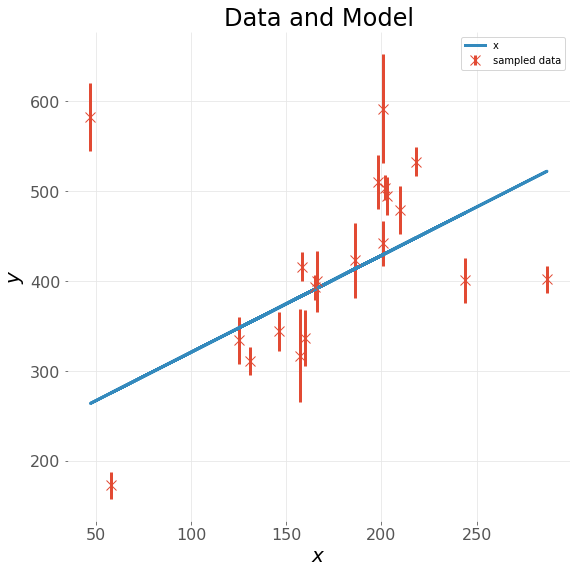

In [7]:
fig = plt.figure(figsize=(9,9))
ax  = fig.add_subplot(111, xlabel=r'$x$', ylabel=r'$y$', title = 'Data and Model')
ax.errorbar(data['x'],data['y'],yerr=data['dy'], marker='x', ls='None', label='sampled data')
ax.plot(data['x'], xopt[0]*data['x'] + xopt[1])

plt.legend(loc=0);

# The Full "Exponential" Model

To consider outliers, we introduce additional integer variables $q_i = 0,1$, which represent our state of belief regarding the goodness of the each point $i$. 
Then we must also introduce the probability that a point is good or bad $P_b$.
We model the outliers assuming that they are scattered around some average value $Y_b$ with a variance $V_b$.

\begin{align}
P(X | D I) &\propto P(D | X I ) P (X | I) \\
X &: \textrm{model parameters}\, (m, b, \{q_i\}, P_b, Y_b, V_b) \\
m &: \textrm{slope}\\
b &: \textrm{intercept}\\
q_i &: \textrm{point $i$ is good (1) or bad (0)} \\
V_b &: \textrm{variance of bad points}
\end{align}

Now let's look closer at the likelihood function $P(D|XI)$. Assuming the data are independent of eachother we have

\begin{align}
L &= P(D|XI) = \prod P(y_i | XI) = \prod\left[ P_{fg}(y_i | m, b, I)^{q_i} \cdot P_{bg}(y_i | Y_b, V_b)^{1-q_i} \right]
\end{align}

\begin{align}
\log{L} &= \sum_i\left[q_i\log{P_{fg}(y_i| m, b, I)} + (1-q_i) \log{P_{bg}(y_i|Y_b,V_b)}\right] \\
&= \sum_{\textrm{good}} \log{P_{fg}(y_i|m, b, I)} + \sum_{\textrm{bad}}\log{P_{bg}(y_i| Y_b, V_b, I)} \\
&= \sum_{\textrm{good}}\log{\left[\frac{1}{\sqrt{2\pi\sigma_i^2}}\exp\left[\frac{-(y_i - m x_i - b)^2}{2\sigma_i^2}\right]\right]} + \sum_{\textrm{bad}}\log{\left[\frac{1}{\sqrt{2\pi \left(V_i^2 + \sigma_i^2\right)}} \exp{\left[-\frac{(y_i - Y_b)^2}{2 \left(V_b^2 + \sigma_i^2\right)}\right]}\right]} \\
&= \sum_{\textrm{good}}\left[-\frac{\left(y_i - m x_i - b\right)^2}{2\sigma_i^2} - \frac{1}{2}\log{2\pi\sigma_i^2}\right] +
\sum_{\textrm{bad}}\left[-\frac{\left(y_i - Y_b\right)^2}{2 \left(V_b^2+\sigma_i^2\right)} - \frac{1}{2}\log{2\pi \left(V_i^2+\sigma_i^2\right)}\right]
\end{align}

All that remains is to specify the priors, 

\begin{align}
P(X| I) &= P(\left\{q_i\right\} | P_b, I) \cdot P(m, b, P_b, Y_b, V_b) \\
p(\left\{q_I\right\}) &= \prod_i \left[1 - P_b\right]^{q_i} \left[P_b\right]^{1-q_i}
\end{align}

Here we assume a Bernoulli distribution for the goodness/badness of each of the points. 
Now, let's see how to do this in PYMC.

Since the posterior we are interested in is not one of the built-in distributions, we must define our own distribution.
All we need to do is specify the corresponding $\log p$ function

In [15]:
# https://docs.pymc.io/advanced_theano.html
# y_in = m x_i + b
def logp(y_obs, is_good, y_in, sig_in, y_out, sig_out):
    logp_in = -0.5*is_good*(((y_obs - y_in)/sig_in)**2 + tt.log(2*np.pi*sig_in**2))
    logp_out= -0.5*(1-is_good)*((y_obs - y_out)**2/(sig_out**2 + sig_in**2) + tt.log(2*np.pi*(sig_out**2 + sig_in**2)))
    return tt.sum(logp_in + logp_out)

with pm.Model() as model:
    # priors for unkown line model parameters (m,b)
    m = pm.Uniform('m', lower=0, upper = 10)
    b = pm.Uniform('b', lower=-800, upper = 800)
    y_in = m*data['x'] + b
    
    # priors for outlier parameters (Y_b, V_b)
    y_out      = pm.Uniform('y_out', lower=-800, upper=800)
    logsig_out = pm.Uniform('logsig_out', lower=-10, upper=10)
    sig_out    = pm.Deterministic('sig_out', tt.exp(logsig_out))
    
    # inlier / outlier classification (P_b, {q_i})
    p_good  = pm.Uniform('p_good', lower=0, upper=1)
    is_good = pm.Bernoulli('is_good', p=p_good, shape=data['x'].shape)
    
    # observed data as Theano shared variables ~ global data
    y_obs  = th.shared(np.asarray(data['y'], dtype=th.config.floatX), name='y_obs')
    sig_in = th.shared(np.asarray(data['dy'], dtype=th.config.floatX), name='sig_in')
    
    likelihood = pm.DensityDist('likelihood', logp,
                                observed={'y_obs': y_obs, 'is_good': is_good,
                                          'y_in' : y_in,  'sig_in' : sig_in,
                                          'y_out': y_out, 'sig_out': sig_out})

In [16]:
# make sure there are no divergences with initial point
for RV in model.basic_RVs:
    print(RV.name, RV.logp(model.test_point))

m_interval__ -1.3862943611198906
b_interval__ -1.3862943611198906
y_out_interval__ -1.3862943611198906
logsig_out_interval__ -1.3862943611198906
p_good_interval__ -1.3862943611198906
is_good -13.862943611198906
likelihood -4050.013662916293


In [17]:
with model:
    traces = pm.sample(10000, tune=20000, progressbar=True)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [p_good, logsig_out, y_out, b, m]
>BinaryGibbsMetropolis: [is_good]
Sampling 2 chains: 100%|██████████| 60000/60000 [01:57<00:00, 512.33draws/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


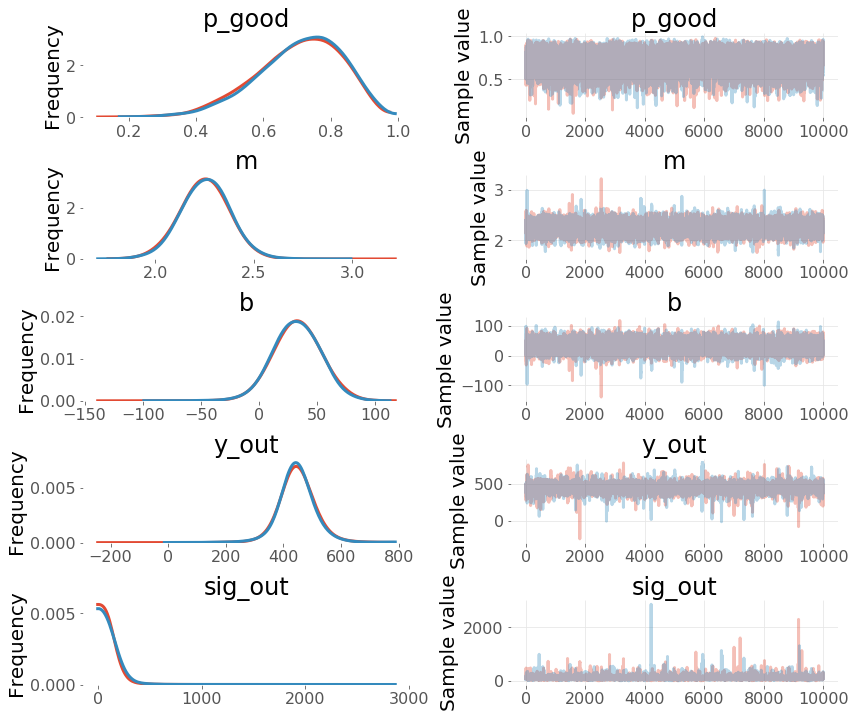

In [18]:
pm.traceplot(traces, varnames={'m', 'b', 'y_out', 'sig_out', 'p_good'});

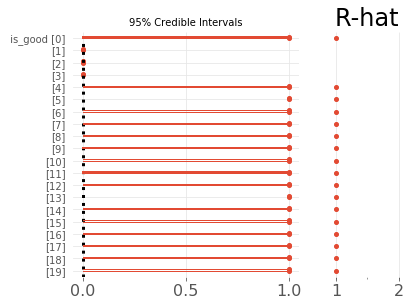

In [19]:
pm.forestplot(traces, varnames=['is_good']);

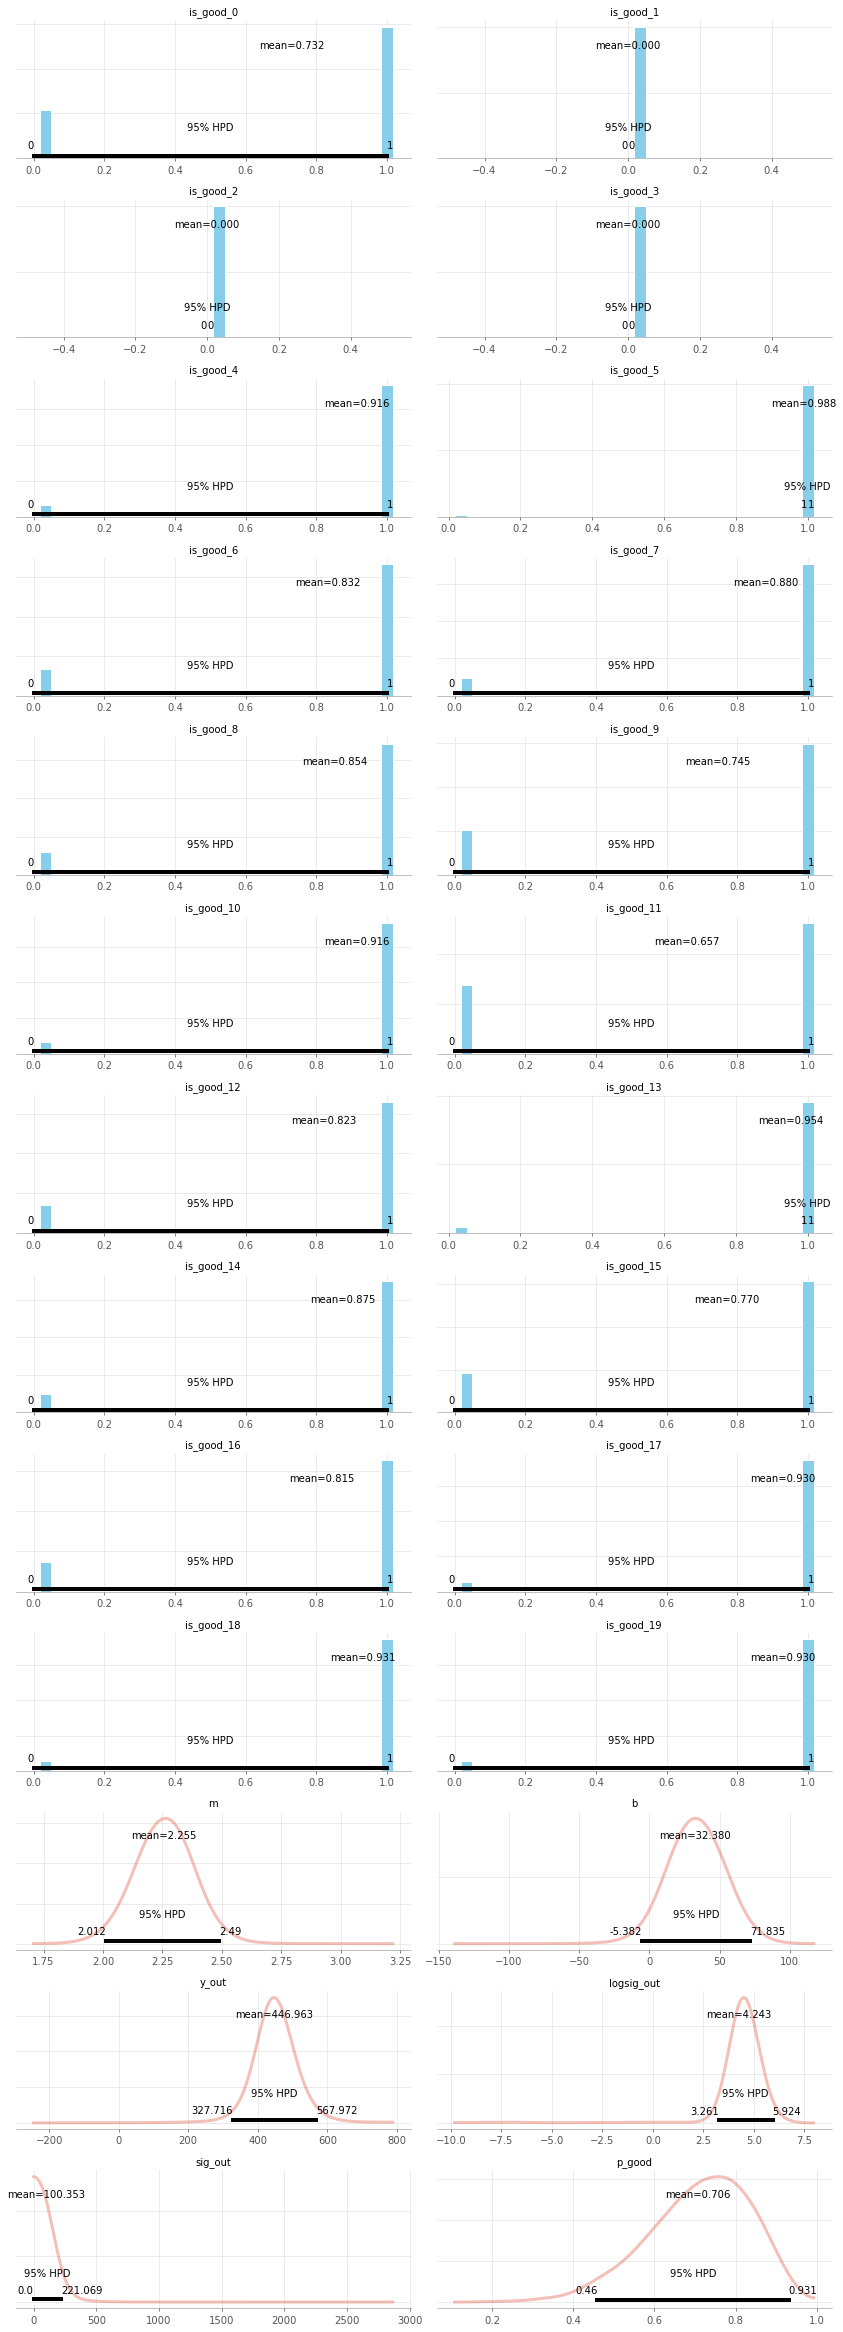

In [20]:
pm.plot_posterior(traces, kde_plot=True);

To identify inliers outliers, we can use the hpd (highest posterior density) for each of the $q_i$ values. By default it returns the smallest region containing 95% of the values. Thus, if the hpd is $[0,0]$ or $[1,1]$ we can be fairly confident the point is bad or good, respectively. If the hpd is $[0,1]$, then we will mark the points as maybes, although the posterior probabilities are highly peaked

In [21]:
out_hpd = pm.stats.hpd(traces['is_good'])
outliers= np.array([x[0] == 0 and x[1] == 0 for x in out_hpd])
maybes  = np.array([x[0] == 0 and x[1] == 1 for x in out_hpd])
insiders= np.array([x[0] == 1 and x[1] == 1 for x in out_hpd])
print(f'inside  = {np.sum(insiders)}')
print(f'maybe   = {np.sum(maybes)}')
print(f'outlier = {np.sum(outliers)}')

inside  = 2
maybe   = 15
outlier = 3


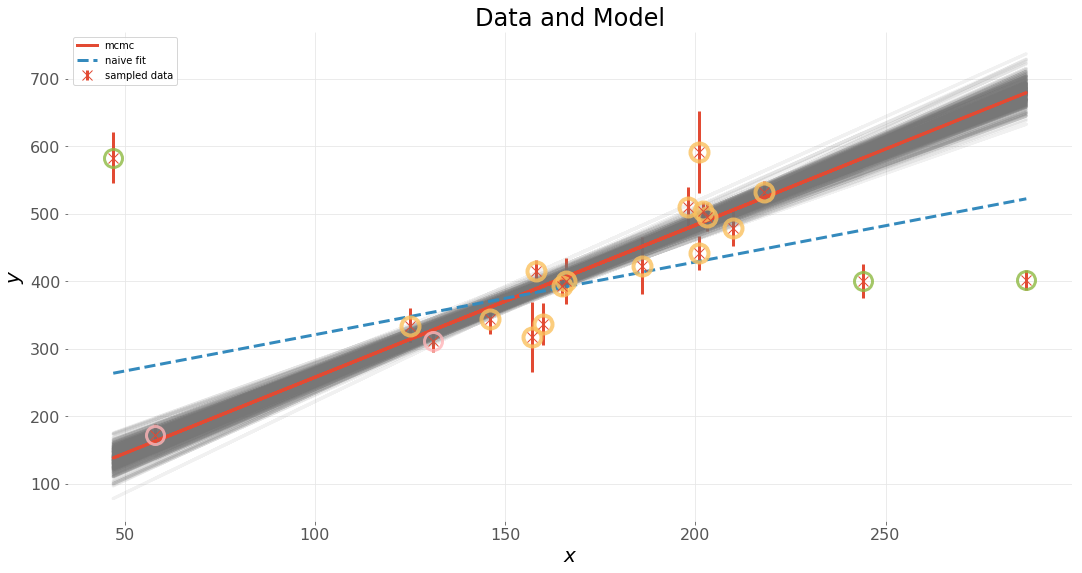

In [23]:
fig = plt.figure(figsize=(18,9))
ax  = fig.add_subplot(111, xlabel=r'$x$', ylabel=r'$y$', title = 'Data and Model')
x, y, dy = data['x'].values, data['y'].values, data['dy'].values

for _m, _b in zip(traces['m'][-20000::50], traces['b'][-20000::50]):
    ax.plot(x, _m*x+_b, c='C3', alpha=0.1)

xs = np.sort(x)
ax.errorbar(x,y,yerr=dy,marker='x', ls='None', label='sampled data', color='C0')
ax.plot(x, np.mean(traces['m'])*x + np.mean(traces['b']), label='mcmc', color='C0')
ax.plot(xs, xopt[0]*xs + xopt[1], label='naive fit', color='C1', ls='--')

ax.plot(x[outliers], y[outliers], 'ro', ms=18, mfc='none', mec='C5', mew=3, alpha=0.8)
ax.plot(x[maybes], y[maybes], 'ro', ms=18, mfc='none', mec='C4', mew=4, alpha=0.8)
ax.plot(x[insiders], y[insiders], 'ro', ms=18, mfc='none', mec='C6', mew=3, alpha=0.8)

plt.legend(loc=0)
plt.show()

Alternatively, we can use the ratio of the posteriors (estimated from the frequencies of good/bad) for each point, to define the odds and the evidence for each. Here we are using Jayne's definitions. The odds for a given hypothesis, i.e., $i$ is a good point is defined as

\begin{align}
O(q_i = 1 | D X) &\equiv \frac{P(q_i = 1 | D X)}{P(q_i = 0 | D X)}
\end{align}

The evidence is 

\begin{align}
e(q_i = 1 | D X) &\equiv 10 \log_{10}{O(q_i = 1 | D X)}
\end{align}

This provies three scales for measuring our degrees of belief of $q_i$: probabilities, odds, and evidence. It turns out we have a better intituiton for evidence, given in decibels. For a detailed discussion see Jaynes book (Ch 4.2). $3$db corresponds to a factor of 2, $10$db to a factor of 10, and $13$db corresponds to a probability of $95%$ (i.e. the standard $2\sigma$ criteria).

Let's calculate the evidence, odds, probatilibty table for each of the points

In [25]:
evidence = pd.DataFrame({'p':[np.average(traces['is_good'][:,i]) for i in range(len(x))]})
evidence['O'] = evidence['p']/(1-evidence['p'])
evidence['e'] = 10*np.log10(evidence['O'])
evidence

,p,O,e
0,0.73155,2.725088,4.353806
1,0.00000,0.000000,-inf
2,0.00000,0.000000,-inf
3,0.00000,0.000000,-inf
4,0.91565,10.855365,10.356444
5,0.98810,83.033613,19.192539
6,0.83215,4.957700,6.952803
7,0.88000,7.333333,8.653014
8,0.85390,5.844627,7.667568
9,0.74515,2.923877,4.659591


We see that there is $p=0$ ($e=-\infty$) for three of the points. This corresponds to the three clear outliers in the data.  Notice also that these are the only negative evidence values ! This means that all other points are more likely to be good than bad ($p>1/2$). Thus, our previous plot, which simply used the hpd and labelled some points as 'maybes' is misleading. Infact, most of these maybe points show $e > 10$, that is, they are ten times more likely to be good than bad.

Let us use this criteria and replot the data.

In [26]:
insiders = evidence['e'] >= 10
maybe_insiders = np.logical_and(evidence['e'] >= 0, evidence['e'] < 10)
outliers = evidence['e'] <= -10
maybe_outliers = np.logical_and(evidence['e'] <=0, evidence['e'] > -10)

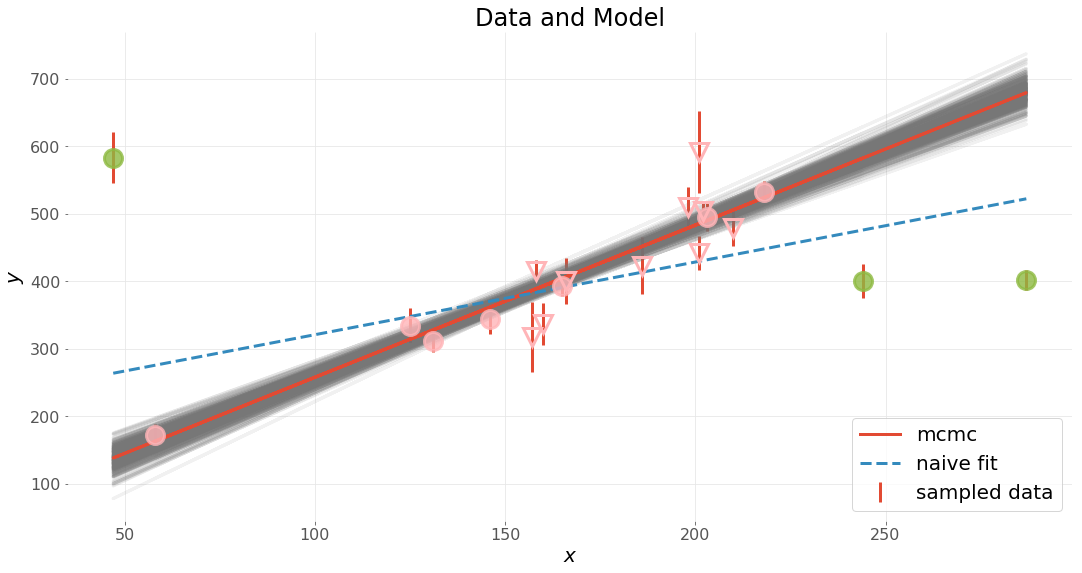

In [30]:
fig = plt.figure(figsize=(18,9))
ax  = fig.add_subplot(111, xlabel=r'$x$', ylabel=r'$y$', title = 'Data and Model')
x, y, dy = data['x'].values, data['y'].values, data['dy'].values

for _m, _b in zip(traces['m'][-20000::50], traces['b'][-20000::50]):
    ax.plot(x, _m*x+_b, c='C3', alpha=0.1)

xs = np.sort(x)
ax.errorbar(x,y,yerr=dy,marker='None', ls='None', label='sampled data', color='C0')
ax.plot(x, np.mean(traces['m'])*x + np.mean(traces['b']), label='mcmc', color='C0')
ax.plot(xs, xopt[0]*xs + xopt[1], label='naive fit', color='C1', ls='--')

ax.plot(x[outliers], y[outliers], 'o', ms=18, color='C5', mew=3, alpha=0.8)
ax.plot(x[maybe_outliers], y[maybe_outliers], 'v', ms=18, mfc='none', mec='C5', mew=3)

ax.plot(x[insiders], y[insiders], 'o', ms=18,  color='C6', mew=3, alpha=0.8)
ax.plot(x[maybe_insiders], y[maybe_insiders], 'v', ms=18, mfc='none', mec='C6', mew=3)

plt.legend(loc=4, fontsize=20)
plt.show()

Pink (green) colors correspond to points that are more likely to be good (bad). Filled circles represent points with absolute evidence greater than $10$db, empty triangles represent points with absolute evidence less than $10$db.

Note that we did not throw away any of the data, out probabilistic model accounts for the possibility of bad points and computes the model parameters accordingly. The final estimate for $m,b$ is obtained my marginalization, averaging over all the other parameters.

# The Marginalized "Mixture" Model

If we don't care about which point is good or bad, we can marginalize over the $q_i$ and arrive at the following model, which is what is done in the paper. It's considerably simpler. It assumes that every point is drawn from a mixture of good/bad data, where the probability to be good or bad is of course equal for all the points.

The log of the posterior is now
\begin{align}
L &= P(D|XI) = \prod P(y_i | XI) = \prod\left[(1-P_b) P_{fg}(y_i | m, b, I) + P_b P_{bg}(y_i | Y_b, V_b) \right]\\
\log L &= \sum_i \log{\left[(1-P_b) P_{fg}(y_i | m, b, I) + P_b P_{fg}(y_i | Y_b, V_b)\right] }\\
&= \sum_i\log{\left[\frac{(1-P_b)}{\sqrt{2\pi \sigma_i^2}} \exp\left[-\frac{\left(y_i - m x_i - b\right)^2}{2\sigma_i^2}\right] + 
\frac{P_b}{\sqrt{2\pi\left(V_b^2 + \sigma_i^2\right)}} \exp{\left[-\frac{(y_i - Y_b)^2}{2\left(V_b^2 + \sigma_i^2\right)}\right]}\right]}
\end{align}

In [35]:
# https://docs.pymc.io/advanced_theano.html
# y_in = m x_i + b
def logp(y_obs, p_good, y_in, sig_in, y_out, sig_out):
    p_fg    = p_good / (tt.sqrt(2*np.pi*sig_in**2)) * tt.exp(-(y_obs - y_in)**2/(2*sig_in**2))
    p_bg    = (1-p_good) / (tt.sqrt(2*np.pi*(sig_out**2 + sig_in**2))) * tt.exp(-(y_obs - y_out)**2/(2*(sig_out**2 + sig_in**2))) 
    return tt.sum(tt.log(p_fg + p_bg))

with pm.Model() as model:
    # priors for unkown line model parameters (m,b)
    m = pm.Uniform('m', lower=0, upper = 10)
    b = pm.Uniform('b', lower=-800, upper = 800)
    y_in = m*data['x'] + b
    
    # priors for outlier parameters (Y_b, V_b)
    y_out      = pm.Uniform('y_out', lower=-800, upper=800)
    logsig_out = pm.Uniform('logsig_out', lower=-10, upper=10)
    sig_out    = pm.Deterministic('sig_out', tt.exp(logsig_out))
    
    # inlier / outlier classification (P_b)
    p_good  = pm.Uniform('p_good', lower=0, upper=1)
    
    # observed data as Theano shared variables ~ global data
    y_obs  = th.shared(np.asarray(data['y'], dtype=th.config.floatX), name='y_obs')
    sig_in = th.shared(np.asarray(data['dy'], dtype=th.config.floatX), name='sig_in')
    
    likelihood = pm.DensityDist('likelihood', logp,
                                observed={'y_obs': y_obs, 'p_good': p_good,
                                          'y_in' : y_in,  'sig_in' : sig_in,
                                          'y_out': y_out, 'sig_out': sig_out})

In [36]:
# make sure there are no divergences with initial point
for RV in model.basic_RVs:
    print(RV.name, RV.logp(model.test_point))

m_interval__ -1.3862943611198906
b_interval__ -1.3862943611198906
y_out_interval__ -1.3862943611198906
logsig_out_interval__ -1.3862943611198906
p_good_interval__ -1.3862943611198906
likelihood -3828.6551949892696


In [37]:
with model:
    traces = pm.sample(10000, tune=20000, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_good, logsig_out, y_out, b, m]
Sampling 2 chains: 100%|██████████| 60000/60000 [01:14<00:00, 803.05draws/s]
The number of effective samples is smaller than 10% for some parameters.


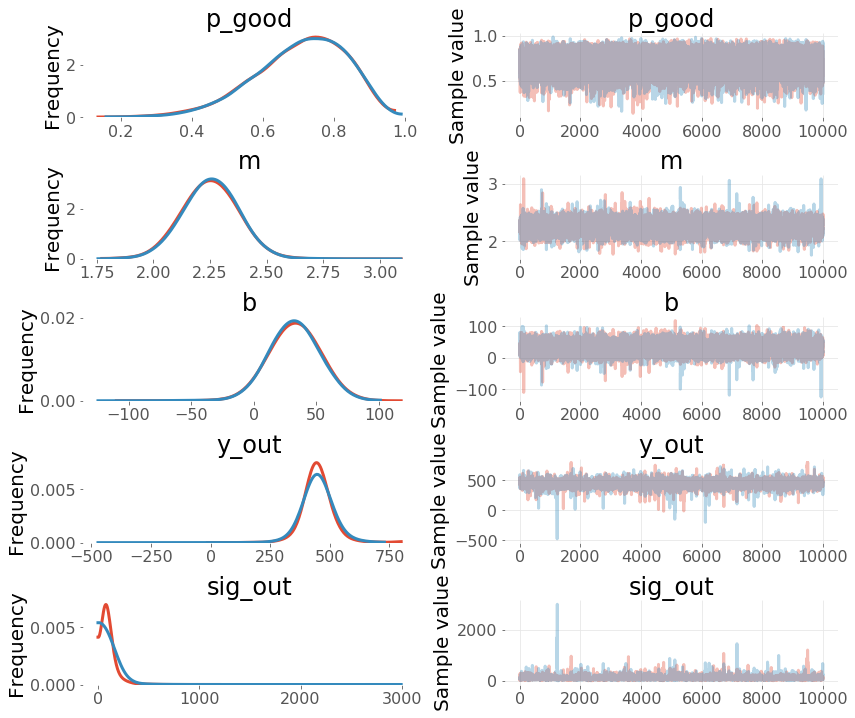

In [38]:
pm.traceplot(traces, varnames={'m', 'b', 'y_out', 'sig_out', 'p_good'});

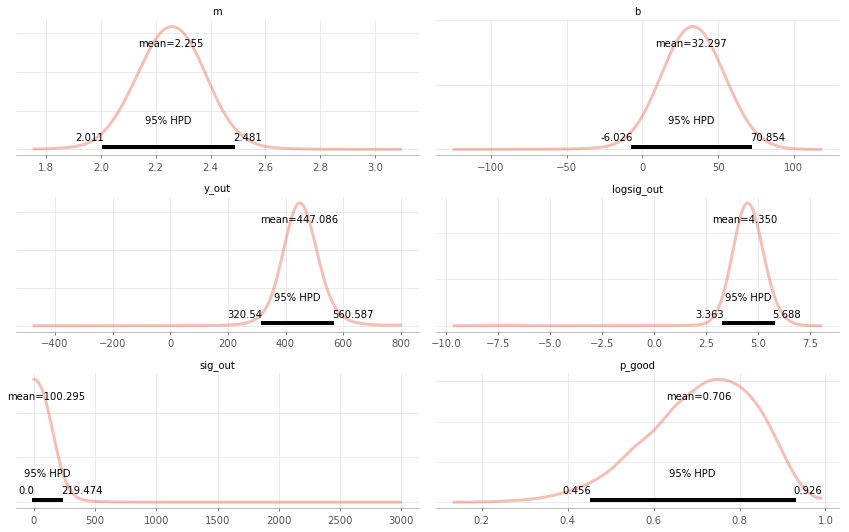

In [39]:
pm.plot_posterior(traces, kde_plot=True);

In [40]:
map_estimate = pm.find_MAP(model=model)
map_estimate

/opt/anaconda3/envs/ML/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -125.23, ||grad|| = 0.0030732: 100%|██████████| 54/54 [00:00<00:00, 2279.63it/s]  


{'m_interval__': array(-1.23171174),
 'b_interval__': array(0.08004918),
 'y_out_interval__': array(1.26345712),
 'logsig_out_interval__': array(0.91158803),
 'p_good_interval__': array(1.06013242),
 'm': array(2.25881972),
 'b': array(32.00258331),
 'y_out': array(447.39305163),
 'logsig_out': array(4.26650027),
 'sig_out': array(71.27176646),
 'p_good': array(0.74271585)}

The results for the mixture model are of course consistent with the full model.
In this case, the posterior probabilities for $m$ and $b$ are well approximated by Gaussian, and the MAP and mean values coincide.

2.258819724401973 32.00258331088128


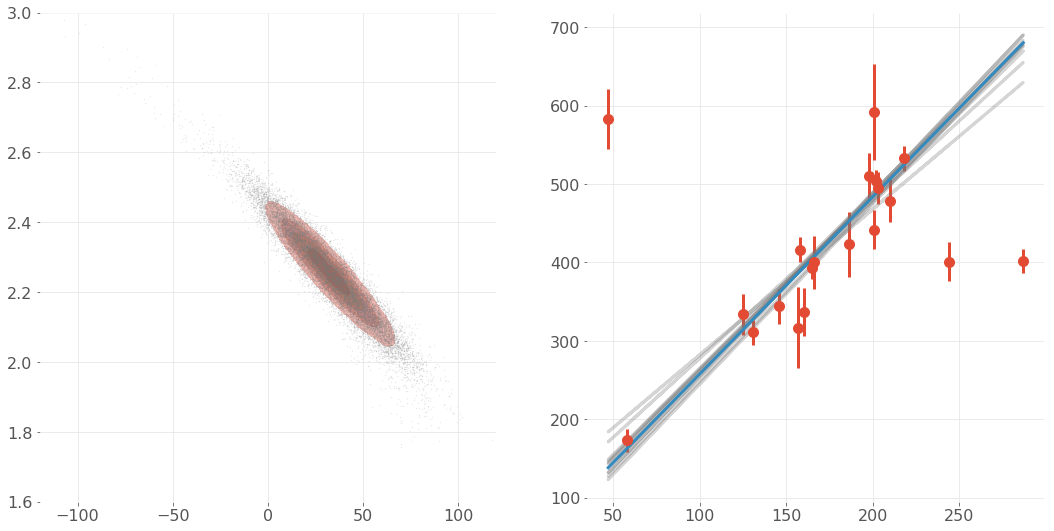

In [42]:
map_m = map_estimate['m']
map_b = map_estimate['b']
print(map_m, map_b)

fig, [ax,bx] = plt.subplots(figsize=(18,9), ncols=2)
sns.kdeplot(traces['b'], traces['m'], shade=True, shade_lowest=False, n_levels=4,ax=ax)
ax.scatter(traces['b'], traces['m'], marker='.', s=0.5, alpha=0.2, color='gray')

bx.errorbar(x, y, dy, ls='None', marker='o')
for _m, _b in zip(traces['m'][-10000::1000], traces['b'][-10000::1000]):
    bx.plot(x, _m*x+_b, c='C3', alpha=0.3)
bx.plot(xs, map_m*xs + map_b, lw=3)

ax.set_xlim(-120,120)
ax.set_ylim(1.6, 3.0)
plt.show()

# The Full "Exponential" Model -- with full uncertainties -- 

To accound for uncertainties in $x$ and $y$, and their correlations, we can follow exactly the same procedure as before, but now, we consider points in 2-d space $z_i = (x_i,y_i)$. The generalized normal distribution is then ($k=2$)

\begin{align}
P({\bf{z}}_i | X I) &= \frac{1}{\sqrt{(2\pi)^k \det{\Sigma}}} \exp{\left[-\frac{1}{2}\left({\bf{z}}_i - {\bf{Z}}\right)^{T} \Sigma_i^{-1} \left({\bf{z}}_i - {\bf{Z}}\right)\right]}
\end{align}

\begin{align}
\log{L} &= \sum_i\left[q_i\log{P_{fg}(z_i| m, b, I)} + (1-q_i) \log{P_{bg}(z_i|Y_b,V_b)}\right] \\
&= \sum_{\textrm{good}} \log{P_{fg}(z_i|m, b, I)} + \sum_{\textrm{bad}}\log{P_{bg}(z_i| Y_b, V_b, I)} \\
&= \sum_{\textrm{good}}\left[-\frac{1}{2}\left(z_i - Z\right)^T\Sigma_i^{-1}\left(z_i - Z\right) - \frac{1}{2}\log{\left(4\pi^2\det\Sigma\right)}\right] +
\sum_{\textrm{bad}}\left[-\frac{1}{2}\left(z_i - Z_b\right)^T\left(\Sigma_{b} + \Sigma\right)^{-1}\left(z-Z_b\right) - \frac{1}{2}\log{\left(4\pi^2 \det{\left(\Sigma_b+\Sigma\right)}\right)}\right]
\end{align}

In [48]:
from theano.tensor.nlinalg import matrix_inverse, det

In [ ]:
# ... work in progress
sig_in = th.shared(Σ, name='sig_in')
isig_in, _ = theano.scan(fn = lambda x:matrix_inverse(x),  sequences = [sig_in])
isig_out,_ = theano.scan(fn = lambda x,y: matrix_inverse(x,y), seque)
inverse_in = theano.function([sig_in], isig_in)

def logp(x_obs, y_obs, is_good, x_in, y_in, sig_in, y_out, sig_out):
    isig_in, _ = theano.scan(fn = lambda x: matrix_inverse(x), sequences = [sig_in])
    isig_out,_ = theano.scan(fn = lambda x,y: matrix_inverse(x + y), sequences= )
    logp_in = -0.5*is_good*(tt.batched_dot(z_in.T, tt.batched_dot(isig_in, z_in))+ tt.log(4*np.pi**2/det(isig_in)))
    logp_out= -0.5*(1-is_good)*(tt.batched_dot(z_out.T, tt.batched_dot(isig_out, z_out)) + tt.log(4*np.pi**2/det(isig_out)))
    return tt.sum(logp_in + logp_out)

with pm.Model() as model:
    # priors for unkown model parameters
    m = pm.Uniform('m', lower=0, upper = 10)
    b = pm.Uniform('b', lower=-800, upper = 800)
    x_in = pm.Uniform('x_in', lower=0, upper=300, shape=data['x'].shape)
    y_in = pm.Deterministic('y_in', m*x_in + b)
    z_in = tt.stack([x_in, y_in], axis=1)
   
    
    # priors for outlier parameters (Y_b, V_b)
    y_out      = pm.Uniform('y_out', lower=-800, upper=800)
    z_out      = tt.stack([x_in, y_out], axis=1)
    logsig_out = pm.Uniform('logsig_out', lower=-10, upper=10)
#    sig_out0   = tt.zeros_like(sig_in)
#    sig_out    = pm.Deterministic('')
    tensor.set_subtensor
    
    
    # inlier / outlier classification (P_b, {q_i})
    p_good  = pm.Uniform('p_good', lower=0, upper=1)
    is_good = pm.Bernoulli('is_good', p=p_good, shape=data['x'].shape)
    
    # observed data as Theano shared variables ~ global data
    z_obs  = tt.shared(np.stack([data['x'], data['y']], axis=1), name='z_obs')
    
    likelihood = pm.DensityDist('likelihood', logp,
                                observed={'x_obx':x_obs, 'y_obs': y_obs, 'is_good': is_good,
                                          'x_in':x_in, 'y_in' : y_in,  'sigma_in' : sig_in, 
                                          'y_out': y_out, 'sig_out': sig_out})